# Predicting Google Apps Sentiment with Naïve Beyes
This dataset consists of web scraped data of 60,000 app reviews, including the text of the review and sentiment scores. We will try to predict sentiment based on the text through a Bayesian model.

## Data Dictionary


| variable               | class        | description                                           |
|:-----------------------|:-------------|:------------------------------------------------------|
| App                    | character    | The application name                                  |
| Translated_Review      | character    | User review (translated to English)                   |
| Sentiment              | character    | The sentiment of the user - Positive/Negative/Neutral |
| Sentiment_Polarity     | character    | The sentiment polarity score                          |
| Sentiment_Subjectivity | character    | The sentiment subjectivity score                      |

[Source](https://www.kaggle.com/lava18/google-play-store-apps) of dataset.

In [2]:
# Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_curve, roc_auc_score

# Seaborn parameters for data visualization
sns.set(rc={"figure.figsize":(15, 7)})
sns.set_context("notebook")
sns.set_style("white")

In [3]:
reviews = pd.read_csv('review_data.csv', usecols = ["App", "Translated_Review", "Sentiment"])

display(reviews.head())
display(reviews.shape)

,App,Translated_Review,Sentiment
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive
2,10 Best Foods for You,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive
4,10 Best Foods for You,Best idea us,Positive


(64295, 3)

## Data Validation

In [4]:
# Check for missing values
display(reviews.isnull().sum())

# Percentage of null in df
percentage_null = round(sum(reviews.isnull().sum()) / (reviews.shape[0] * reviews.shape[1]), 2)

print("\nNull percentage in the entire dataframe: ", percentage_null)

App                      0
Translated_Review    26868
Sentiment            26863
dtype: int64

Null percentage in the entire dataframe:  0.28


In [5]:
# Remove null values
reviews.dropna(inplace=True)

## Exploratory Data Analysis

1    23998
0    13429
Name: Sentiment, dtype: int64

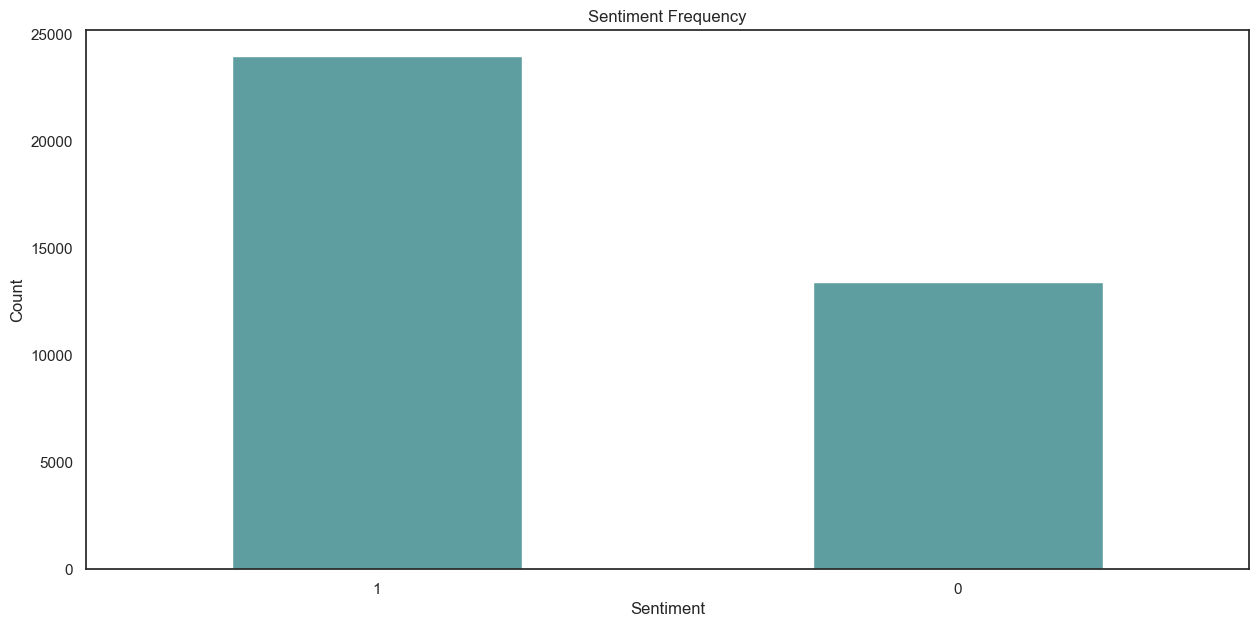

In [58]:
# Count values in Sentiment column
display(reviews.Sentiment.value_counts())

# Plot
ax = reviews.Sentiment.value_counts().plot(kind="bar", color="cadetblue")
ax.set_xlabel("Sentiment")
ax.set_xticklabels(reviews.Sentiment.value_counts().index, rotation = 360)
ax.set_ylabel("Count")
ax.set_title("Sentiment Frequency");

Since neutral sentiment is neither positive nor negative, we can sum negative and neutral into a single "not positive" class and deal with a binary target variable (1 positive, 0 not positive).

In [7]:
# Replace Sentiment column with dummy variables
reviews["Sentiment"] = [1 if x == "Positive" else 0 for x in reviews.Sentiment]

1    23998
0    13429
Name: Sentiment, dtype: int64

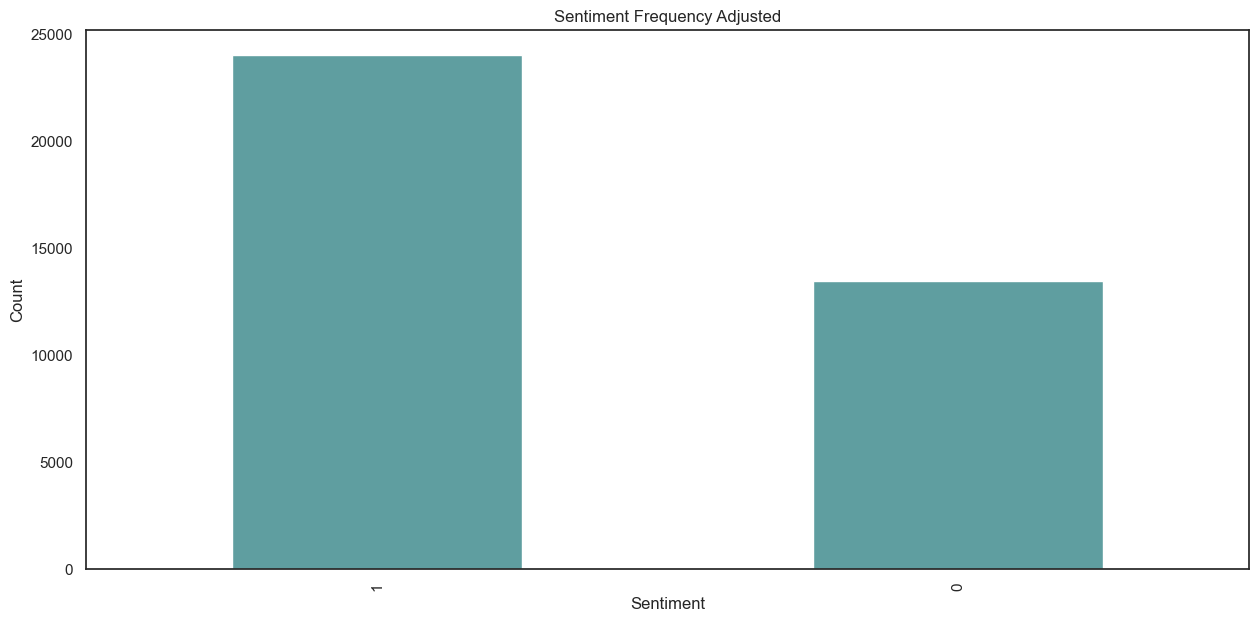

In [49]:
# Count values in adjusted Sentiment column
display(reviews.Sentiment.value_counts())

# Plot
reviews.Sentiment.value_counts().plot(kind="bar", color="cadetblue")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Frequency Adjusted");

The Sentiment variable is binary, so the positive reviews rate for each app is equal to the Sentiment mean for that app. Let's see what the top 10 rated apps are.

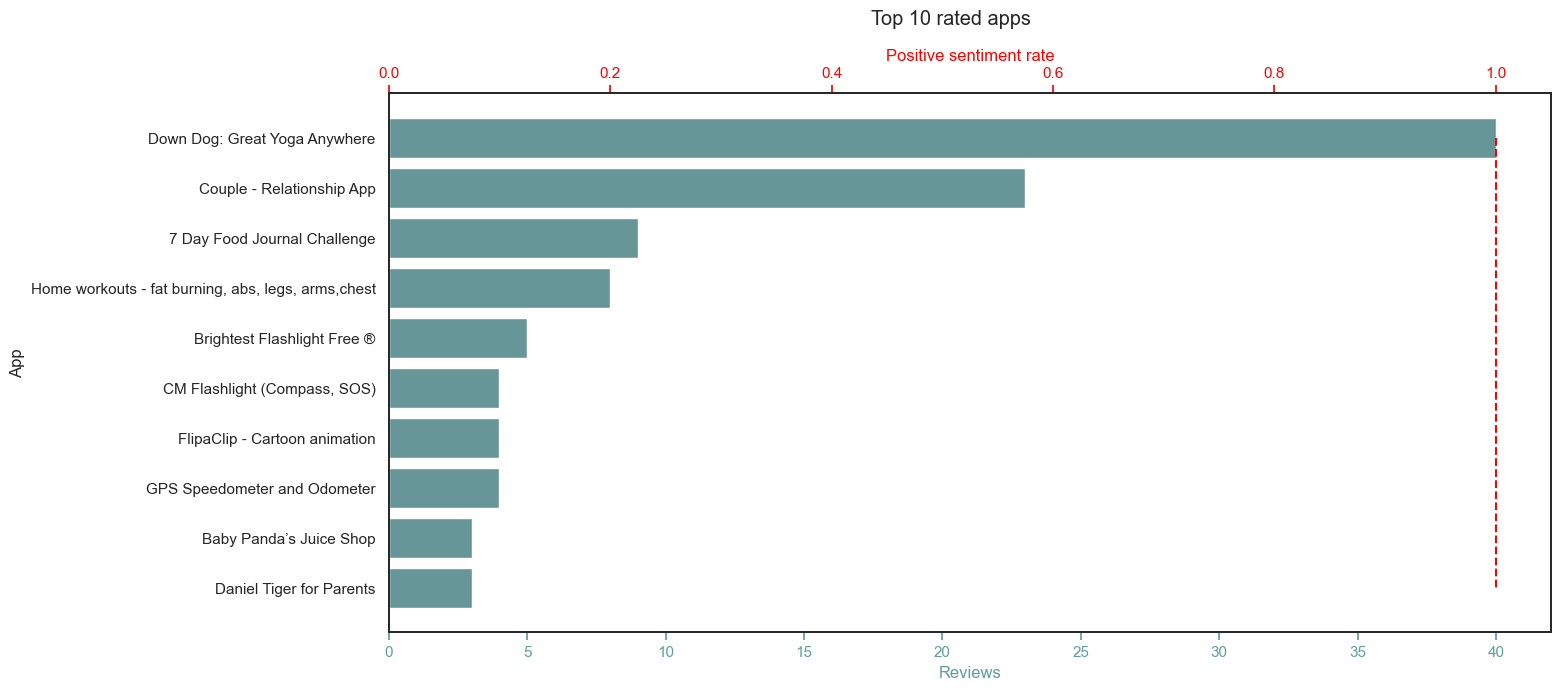

In [79]:
top_rated_app = reviews.groupby("App").Sentiment.agg(["count", "mean"]) \
                        .sort_values(["mean", "count"], ascending=False).reset_index().head(10)

fig, ax = plt.subplots()
sns.barplot(x="count", y="App", data=top_rated_app, color="cadetblue", ax=ax)
ax2 = ax.twiny()
ax2.plot(top_rated_app["mean"], top_rated_app.App, color="red", linestyle="--")
plt.xlim([0,1.05])
ax.set_xlabel("Reviews", color="cadetblue")
ax2.set_xlabel("Positive sentiment rate", color="red")
ax.tick_params("x", colors="cadetblue")
ax2.tick_params("x", colors="red")
fig.suptitle("Top 10 rated apps", y= 1);

All the 10 apps have a positive sentiment rate of 100%!

## Model Development

In [10]:
# Initialize tokenizer
vectorizer = CountVectorizer()

# Select feature column (x) and target column (y)
X = vectorizer.fit_transform(reviews.Translated_Review).todense()
y = reviews.Sentiment

In [11]:
# Compare 3 Naïve Bayes models through cross validsation
models = {"GaussianNB" : GaussianNB(), "MultinomialNB" : MultinomialNB(), "BernoulliNB" : BernoulliNB()}
results = []

for model in models.values():
    cv_scores = cross_val_score(model, X, y, cv=5)
    results.append(cv_scores)

plt.boxplot(results, labels=models.keys())
plt.ylabel("Accuracy")
plt.title("Naïve Bayes models")

'models = {"GaussianNB" : GaussianNB(), "MultinomialNB" : MultinomialNB(), "BernoulliNB" : BernoulliNB()}\nresults = []\n\nfor model in models.values():\n    cv_scores = cross_val_score(model, X, y, cv=5)\n    results.append(cv_scores)\n\nplt.boxplot(results, labels=models.keys())\nplt.ylabel("Accuracy")'

It seems that the BernoulliNB is the best model in terms of accuracy.

In [12]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the model
model = BernoulliNB()

# Fit the model
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Accuracy score
print("Accuracy: ", round(model.score(X_test, y_test),2))

Accuracy:  0.85


## Model Evaluation

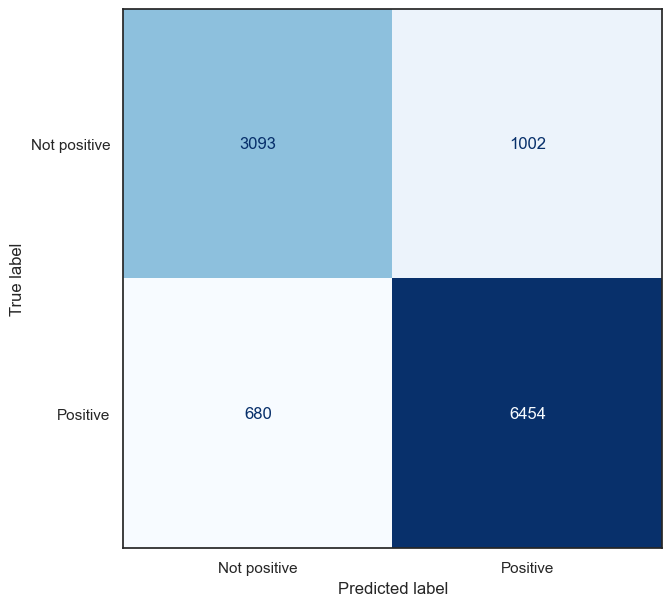

In [13]:
# Plot confusion matrix
plot_confusion_matrix(model, X_test, y_test, cmap = "Blues", colorbar=False, display_labels=['Not positive','Positive'])

In [14]:
# Classification report
print(classification_report(y_test, y_pred, target_names=['Not positive','Positive']))

              precision    recall  f1-score   support

Not positive       0.82      0.76      0.79      4095
    Positive       0.87      0.90      0.88      7134

    accuracy                           0.85     11229
   macro avg       0.84      0.83      0.84     11229
weighted avg       0.85      0.85      0.85     11229



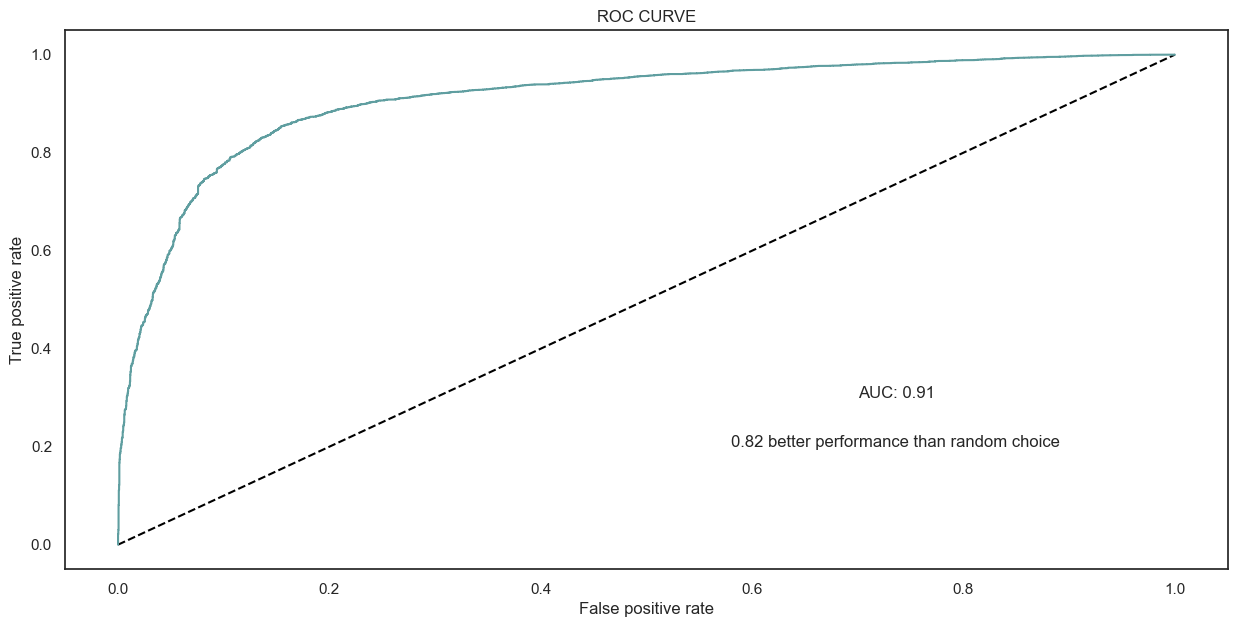

In [81]:
# Predict probability on test data
y_pred_proba = model.predict_proba(X_test)[:,1]

auc = round(roc_auc_score(y_test, y_pred_proba),2)
performance = round((auc / 0.5) - 1, 2)

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1], [0,1], "--", color="black")
plt.plot(fpr, tpr, color="cadetblue")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC CURVE")
plt.annotate("AUC: " + str(auc), xy=[0.7, 0.3], size=12);
plt.annotate(str(performance) + " better performance than random choice", xy=[0.58, 0.2], size=12);

## Making a prediction

In [16]:
# Prediction
prediction = model.predict(vectorizer.transform(["I love this app!",
                                    "Awesome app, so useful.",
                                    "I hate this app, it has many problems!"]).todense())
# Results
np.where(prediction == 1, "Positive", "Not positive")

array(['Positive', 'Positive', 'Not positive'], dtype='<U12')

The predictions are correct!